# Clasificador de sentimiento de texto usando transformadores

**Nombre:** Fernando Márquez Pérez

**No. de Cuenta:**  420004482

In [1]:
from tqdm.notebook import trange, tqdm
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.functional as F
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


### Preprocesamiento

Descargamos y cargamos el [dataset](https://www.kaggle.com/datasets/arnavsharmaas/chatbot-dataset-topical-chat)


In [2]:
df = pd.read_csv("topical_chat.csv")
df

,conversation_id,message,sentiment
0,1,Are you a fan of Google or Microsoft?,Curious to dive deeper
1,1,Both are excellent technology they are helpfu...,Curious to dive deeper
2,1,"I'm not a huge fan of Google, but I use it a...",Curious to dive deeper
3,1,Google provides online related services and p...,Curious to dive deeper
4,1,"Yeah, their services are good. I'm just not a...",Curious to dive deeper
...,...,...,...
188373,8628,"Wow, it does not seem like that long. Since I...",Surprised
188374,8628,"I havent seen that episode, I might google it...",Curious to dive deeper
188375,8628,I don't think I have either. That's an insane...,Curious to dive deeper
188376,8628,"I did, my little brother used to love Thomas ...",Happy


In [3]:
classes = df.sentiment.unique()
classes_dic = {k:v for v,k in enumerate(classes)}

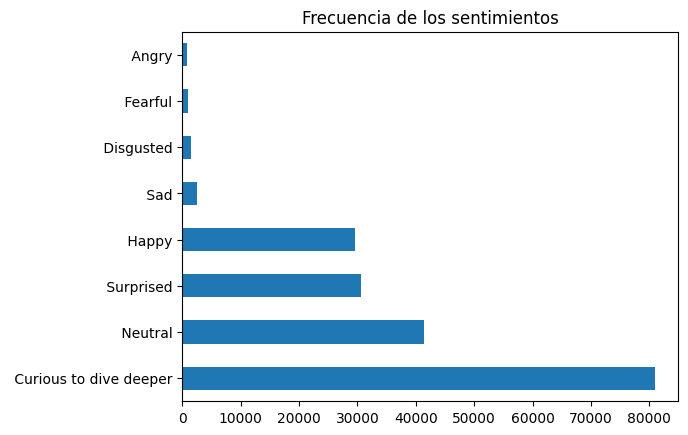

In [4]:
df.sentiment.value_counts().plot(kind="barh",
                                 title="Frecuencia de los sentimientos")
plt.show()

Lo que podemos ver del conjunto es que las clases no están corresctamente balanceadas: *curious to dive deeper* es la clase predominante porque es donde caen todos los mensajes relacionados a preguntas. Es probable que las 4 clases con menos elementos no den buenos resultados.

Para poder trabajar con el transformador necesitamos codificar el texto a tensores y las etiquetas a valores numéricos, para lo que nos apoyaremos de `torchtext`. Crearemos un Dataset para los mensajes con su texto y etiqueta codificados y luego creamos DataLoaders para mejorar entrenamiento.

In [5]:
tokenizer = get_tokenizer("basic_english")
vocab = build_vocab_from_iterator(map(tokenizer, df.message))

In [6]:
vocab(tokenizer(df.message[0]))

[26, 9, 5, 159, 11, 246, 66, 3759, 10]

In [7]:
class MessageDataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.data = df
    d = []
    max_len = 0
    for message in df.message:
      t = torch.tensor(vocab(tokenizer(message)), dtype=torch.int)
      max_len = max(max_len, t.shape[0])
      d.append(t)

    self.X = torch.zeros(len(d), max_len, dtype=torch.int)
    self.masks = torch.ones(len(d), max_len, dtype=torch.bool)

    for i, row in enumerate(d):
      l = row.shape[0]
      self.X[i,:l] = row
      self.masks[i,:l] = torch.zeros(l, dtype=torch.bool)

    self.y = torch.tensor([classes_dic[sentiment] for sentiment in df.sentiment])

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.masks[idx], self.y[idx]

In [8]:
df_train, df_test = train_test_split(df, test_size=0.2)
train_set = MessageDataset(df_train)
test_set = MessageDataset(df_test)

In [9]:
print("Ejemplo de codificación:")
tmp = train_set.data.iloc[0]
print(f"Mensaje:{tmp.message}")
print(f"Etiqueta:{tmp.sentiment}")
print(f"Etiqueta codificada: {train_set[0][2]}")
print("Mensaje codificado:")
print(vocab(tokenizer(tmp.message)))
print("Mensaje codificado con padding:")
print(train_set[0][0])
print("Máscara:")
print(train_set[0][1])

Ejemplo de codificación:
Mensaje: I actually do!  Love music and going to concerts!  Do you like Linkin Park?  They played 324 concerts in 2001 alone.  That's a lot of shows in one year!
Etiqueta: Happy
Etiqueta codificada: 1
Mensaje codificado:
[1, 113, 20, 13, 102, 130, 15, 172, 6, 408, 13, 20, 9, 22, 672, 352, 10, 16, 218, 1578, 408, 14, 1113, 1164, 0, 4, 7, 19, 5, 67, 11, 248, 14, 46, 197, 13]
Mensaje codificado con padding:
tensor([   1,  113,   20,   13,  102,  130,   15,  172,    6,  408,   13,   20,
           9,   22,  672,  352,   10,   16,  218, 1578,  408,   14, 1113, 1164,
           0,    4,    7,   19,    5,   67,   11,  248,   14,   46,  197,   13,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [10]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

Con los datasets preparados, procedemos a crear el modelo.

### Creación del modelo

Optamos por un modelo basado en **transformadores** por probar algo que no habíamos programado durando las clases. Las otras dos posibles propuestas fueron: Alguna variante de RNN y una CNN.

El modelo del transformador se basa en varios componentes:
- Una capa de embedding
- Una capa para la codificación de posición
- Un codificador
- Capas completamente conectadas

En nuestro modelo no utilizamos un decodificador porque no nos preocupamos por generar texto de regreso, sino por obtener la etiqueta del sentimiento.

Copiamos parte de la estructura del transformación de la que se muestra en el artículo *Atention Is All You Need*, que es la referencia que utiliza el [tutorial de pytorch para NLP](https://pytorch.org/tutorials/beginner/transformer_tutorial.html)

In [11]:
# Este código es el tutorial mencionado antes y aplica sen y cos para generar
# una matriz con la información posicional, como lo visto en clase
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [12]:
class SentimentTransformer(nn.Module):
  def __init__(
      self,
      num_tokens,
      model_dim,
      num_heads,
      dim_ff,
      num_layers,
      dropout
  ):
    super().__init__()
    # Modelo de embedding
    self.embedding = nn.Embedding(num_tokens, model_dim)
    # codificador posicional
    self.pos_encoder = PositionalEncoding(model_dim, dropout, num_tokens)
    # codificador
    encoder_layers = nn.TransformerEncoderLayer(
      model_dim, num_heads, dim_ff, dropout, batch_first=True)
    self.encoder = nn.TransformerEncoder(encoder_layers, num_layers)
    # Capa lineal
    self.linear = nn.Linear(model_dim, len(classes))
    self.model_dim = model_dim

  def forward(self, X, mask):
    # Preparamos la matriz
    # Lo multiplicados para darle más peso al embedding al sumar con pos_encoder
    tmp = self.embedding(X) * math.sqrt(self.model_dim)
    tmp = self.pos_encoder(tmp)
    # Entramos al transformador
    res = self.encoder(tmp, src_key_padding_mask=mask)
    output = res.mean(axis=1)
    output = self.linear(output)
    # Devolvemos los logits
    return output


### Entrenamiento

Para entrenar iteramos sobre los datos de entrenamieto y calculamos la pérdida promedio por lote paso a paso.

In [19]:
def train(model, data_loader, epochs, criterion, optimizer, device):
  error = []
  for epoch in range(1, epochs+1):
    model.train()
    # print(f"Epoch {epoch} / {epochs}")
    error_batch, batch_ind = 0, 0
    desc = f"Epoch {epoch} / {epochs}"
    for data, masks, labels in tqdm(data_loader, desc=desc, unit="batch"):
      data, masks, labels = (v.to(device) for v in (data, masks, labels))
      # Calcula el error
      batch_ind += 1
      logits = model(data, None)
      probs = torch.softmax(logits, dim=1)
      loss = criterion(probs, labels)
      # error.append(loss.item())
      error_batch += loss.item()
      
      # Actualiza
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()

      # Muestra datos
      if batch_ind % 100 == 0:
        print(f"batch {batch_ind} loss = {loss}")

    error_batch /= len(data_loader)
    error.append(error_batch)

    print(f"avg loss = {error_batch}")
    model.train()

  return error

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model = SentimentTransformer(len(vocab), 100, 2, 200, 2, 0.2)
optimizer = optim.Adam(model.parameters())
model.to(device)
error = train(model, train_dataloader, 100, criterion, optimizer, device)

Epoch 1 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.867915391921997
batch 200 loss = 1.8053803443908691
batch 300 loss = 1.8365716934204102
batch 400 loss = 1.8990169763565063
batch 500 loss = 1.758430004119873
batch 600 loss = 1.789665699005127
batch 700 loss = 1.6802970170974731
batch 800 loss = 1.8990134000778198
batch 900 loss = 1.8833906650543213
batch 1000 loss = 1.867764949798584
batch 1100 loss = 1.8833869695663452
batch 1200 loss = 1.8365144729614258
batch 1300 loss = 1.9302600622177124
batch 1400 loss = 1.8365126848220825
batch 1500 loss = 1.8208885192871094
batch 1600 loss = 1.8208867311477661
batch 1700 loss = 1.7740134000778198
batch 1800 loss = 1.8677611351013184
batch 1900 loss = 1.8990089893341064
batch 2000 loss = 1.7427635192871094
batch 2100 loss = 1.6958889961242676
batch 2200 loss = 1.7583874464035034
batch 2300 loss = 1.8833845853805542
avg loss = 1.8457378978182555


Epoch 2 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.852135181427002
batch 200 loss = 1.8677592277526855
batch 300 loss = 1.7896353006362915
batch 400 loss = 1.914633870124817
batch 500 loss = 1.8052600622177124
batch 600 loss = 1.8365097045898438
batch 700 loss = 1.8208844661712646
batch 800 loss = 1.9146336317062378
batch 900 loss = 1.836509346961975
batch 1000 loss = 1.883384108543396
batch 1100 loss = 1.883384108543396
batch 1200 loss = 1.8365092277526855
batch 1300 loss = 1.7740097045898438
batch 1400 loss = 1.7740094661712646
batch 1500 loss = 1.7896344661712646
batch 1600 loss = 1.805259108543396
batch 1700 loss = 1.8521339893341064
batch 1800 loss = 1.7896339893341064
batch 1900 loss = 2.024008274078369
batch 2000 loss = 1.8833842277526855
batch 2100 loss = 1.8365092277526855
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.774008870124817
avg loss = 1.8453997967349496


Epoch 3 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7896344661712646
batch 200 loss = 1.8833842277526855
batch 300 loss = 1.8365092277526855
batch 400 loss = 1.852134346961975
batch 500 loss = 1.836509346961975
batch 600 loss = 1.8677592277526855
batch 700 loss = 1.852134346961975
batch 800 loss = 1.805259346961975
batch 900 loss = 1.7896342277526855
batch 1000 loss = 1.7896344661712646
batch 1100 loss = 1.8052594661712646
batch 1200 loss = 1.7740094661712646
batch 1300 loss = 1.867759346961975
batch 1400 loss = 1.8677594661712646
batch 1500 loss = 1.945884346961975
batch 1600 loss = 1.7271344661712646
batch 1700 loss = 1.8052594661712646
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.8677594661712646
batch 2000 loss = 1.7740094661712646
batch 2100 loss = 1.8677594661712646
batch 2200 loss = 1.8208844661712646
batch 2300 loss = 1.9302594661712646
avg loss = 1.8454023385503489


Epoch 4 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.8677594661712646
batch 300 loss = 1.9458844661712646
batch 400 loss = 1.8521344661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.8208844661712646
batch 700 loss = 1.8521344661712646
batch 800 loss = 1.7896344661712646
batch 900 loss = 1.6490094661712646
batch 1000 loss = 1.7896344661712646
batch 1100 loss = 1.8052594661712646
batch 1200 loss = 1.7740094661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.8833844661712646
batch 1500 loss = 1.8521344661712646
batch 1600 loss = 1.8990094661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.7583844661712646
batch 1900 loss = 1.7896344661712646
batch 2000 loss = 1.9458844661712646
batch 2100 loss = 1.8521344661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8453946384401585


Epoch 5 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.8521344661712646
batch 300 loss = 1.8052594661712646
batch 400 loss = 1.8208844661712646
batch 500 loss = 1.9927594661712646
batch 600 loss = 1.9771344661712646
batch 700 loss = 1.8208844661712646
batch 800 loss = 1.758384346961975
batch 900 loss = 1.8521344661712646
batch 1000 loss = 1.7896344661712646
batch 1100 loss = 1.883384346961975
batch 1200 loss = 1.9458844661712646
batch 1300 loss = 1.7583844661712646
batch 1400 loss = 1.820884346961975
batch 1500 loss = 1.852134346961975
batch 1600 loss = 1.820884346961975
batch 1700 loss = 1.8990094661712646
batch 1800 loss = 1.8990094661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.9615094661712646
batch 2100 loss = 1.8677594661712646
batch 2200 loss = 1.8208844661712646
batch 2300 loss = 1.8677594661712646
avg loss = 1.845394627050736


Epoch 6 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.8365094661712646
batch 300 loss = 1.8052594661712646
batch 400 loss = 1.7740094661712646
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.805259346961975
batch 700 loss = 1.899009346961975
batch 800 loss = 1.742759346961975
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.9458844661712646
batch 1100 loss = 1.836509346961975
batch 1200 loss = 1.8833844661712646
batch 1300 loss = 1.9458844661712646
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.836509346961975
batch 1600 loss = 1.820884346961975
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.7583844661712646
batch 2000 loss = 1.852134346961975
batch 2100 loss = 1.7896344661712646
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8454024006100471


Epoch 7 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.8677594661712646
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.8677594661712646
batch 500 loss = 1.758384346961975
batch 600 loss = 1.8990094661712646
batch 700 loss = 1.883384346961975
batch 800 loss = 1.774009346961975
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.9458844661712646
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.8208844661712646
batch 1300 loss = 1.820884346961975
batch 1400 loss = 1.899009346961975
batch 1500 loss = 1.852134346961975
batch 1600 loss = 1.7427594661712646
batch 1700 loss = 1.7115094661712646
batch 1800 loss = 1.7896344661712646
batch 1900 loss = 1.8208844661712646
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.9771344661712646
batch 2200 loss = 1.7740094661712646
batch 2300 loss = 1.9927594661712646
avg loss = 1.845392019581643


Epoch 8 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7740094661712646
batch 200 loss = 1.867759346961975
batch 300 loss = 1.852134346961975
batch 400 loss = 1.774009346961975
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.8833844661712646
batch 700 loss = 1.789634346961975
batch 800 loss = 1.7271344661712646
batch 900 loss = 1.8677594661712646
batch 1000 loss = 1.8365094661712646
batch 1100 loss = 1.7740094661712646
batch 1200 loss = 1.8990094661712646
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.8052594661712646
batch 1500 loss = 1.7740094661712646
batch 1600 loss = 1.8052594661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 1.899009346961975
batch 2100 loss = 1.9302594661712646
batch 2200 loss = 1.8833844661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8453842425801952


Epoch 9 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.836509346961975
batch 200 loss = 1.8208844661712646
batch 300 loss = 1.774009346961975
batch 400 loss = 1.9302594661712646
batch 500 loss = 1.8365094661712646
batch 600 loss = 1.8833844661712646
batch 700 loss = 1.899009346961975
batch 800 loss = 1.7740094661712646
batch 900 loss = 1.9302594661712646
batch 1000 loss = 1.7427594661712646
batch 1100 loss = 1.8365094661712646
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.8052594661712646
batch 1400 loss = 1.7896344661712646
batch 1500 loss = 1.8677594661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.774009346961975
batch 1800 loss = 1.9302594661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.789634346961975
batch 2100 loss = 1.867759346961975
batch 2200 loss = 1.8990094661712646
batch 2300 loss = 1.758384346961975
avg loss = 1.8454023886638082


Epoch 10 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.6958844661712646
batch 200 loss = 1.8521344661712646
batch 300 loss = 1.8521344661712646
batch 400 loss = 1.727134346961975
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.9302594661712646
batch 700 loss = 1.742759346961975
batch 800 loss = 1.8365094661712646
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.8365094661712646
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.805259346961975
batch 1400 loss = 1.8208844661712646
batch 1500 loss = 1.8990094661712646
batch 1600 loss = 1.9302594661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.852134346961975
batch 1900 loss = 1.883384346961975
batch 2000 loss = 1.7583844661712646
batch 2100 loss = 1.8521344661712646
batch 2200 loss = 1.7427594661712646
batch 2300 loss = 1.8521344661712646
avg loss = 1.845392006015575


Epoch 11 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.774009346961975
batch 300 loss = 1.8990094661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.7896344661712646
batch 700 loss = 1.9458844661712646
batch 800 loss = 1.8833844661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.7740094661712646
batch 1100 loss = 1.820884346961975
batch 1200 loss = 1.8833844661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.758384346961975
batch 1600 loss = 1.7583844661712646
batch 1700 loss = 1.789634346961975
batch 1800 loss = 1.789634346961975
batch 1900 loss = 1.8677594661712646
batch 2000 loss = 1.8990094661712646
batch 2100 loss = 1.8208844661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.8677594661712646
avg loss = 1.84539460290516


Epoch 12 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.836509346961975
batch 200 loss = 1.8833844661712646
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.774009346961975
batch 500 loss = 1.7896344661712646
batch 600 loss = 1.9146344661712646
batch 700 loss = 1.9458844661712646
batch 800 loss = 1.7583844661712646
batch 900 loss = 1.9458844661712646
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.820884346961975
batch 1200 loss = 1.7583844661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.9302594661712646
batch 1500 loss = 1.852134346961975
batch 1600 loss = 1.8208844661712646
batch 1700 loss = 1.8208844661712646
batch 1800 loss = 1.7896344661712646
batch 1900 loss = 1.883384346961975
batch 2000 loss = 1.930259346961975
batch 2100 loss = 1.758384346961975
batch 2200 loss = 1.9615094661712646
batch 2300 loss = 1.9771344661712646
avg loss = 1.8453920047500838


Epoch 13 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8990094661712646
batch 200 loss = 1.774009346961975
batch 300 loss = 1.8990094661712646
batch 400 loss = 2.0240094661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.8990094661712646
batch 700 loss = 1.789634346961975
batch 800 loss = 1.899009346961975
batch 900 loss = 1.711509346961975
batch 1000 loss = 1.727134346961975
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.9146344661712646
batch 1300 loss = 1.867759346961975
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.8365094661712646
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.820884346961975
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.8052594661712646
batch 2100 loss = 1.8052594661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.8990094661712646
avg loss = 1.8453790238961545


Epoch 14 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.867759346961975
batch 200 loss = 1.8052594661712646
batch 300 loss = 1.8521344661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.9302594661712646
batch 600 loss = 1.774009346961975
batch 700 loss = 1.8052594661712646
batch 800 loss = 1.789634346961975
batch 900 loss = 1.8833844661712646
batch 1000 loss = 1.883384346961975
batch 1100 loss = 1.695884346961975
batch 1200 loss = 1.8208844661712646
batch 1300 loss = 1.774009346961975
batch 1400 loss = 1.7740094661712646
batch 1500 loss = 1.9771344661712646
batch 1600 loss = 1.8208844661712646
batch 1700 loss = 1.8365094661712646
batch 1800 loss = 1.820884346961975
batch 1900 loss = 1.8521344661712646
batch 2000 loss = 1.758384346961975
batch 2100 loss = 1.9302594661712646
batch 2200 loss = 1.8833844661712646
batch 2300 loss = 1.727134346961975
avg loss = 1.8453945997161216


Epoch 15 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.945884346961975
batch 200 loss = 1.711509346961975
batch 300 loss = 1.774009346961975
batch 400 loss = 1.867759346961975
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.8833844661712646
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.9458844661712646
batch 900 loss = 1.7896344661712646
batch 1000 loss = 1.8833844661712646
batch 1100 loss = 1.8990094661712646
batch 1200 loss = 1.9302594661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.7896344661712646
batch 1500 loss = 1.836509346961975
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.7896344661712646
batch 1800 loss = 1.742759346961975
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 1.789634346961975
batch 2100 loss = 1.758384346961975
batch 2200 loss = 1.742759346961975
batch 2300 loss = 1.8521344661712646
avg loss = 1.8454101792819435


Epoch 16 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.820884346961975
batch 200 loss = 1.8833844661712646
batch 300 loss = 1.9615094661712646
batch 400 loss = 1.899009346961975
batch 500 loss = 1.9771344661712646
batch 600 loss = 1.9302594661712646
batch 700 loss = 1.9615094661712646
batch 800 loss = 1.9302594661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.836509346961975
batch 1100 loss = 1.820884346961975
batch 1200 loss = 1.8208844661712646
batch 1300 loss = 1.789634346961975
batch 1400 loss = 1.7740094661712646
batch 1500 loss = 1.9146344661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.789634346961975
batch 1800 loss = 1.9146344661712646
batch 1900 loss = 1.9615094661712646
batch 2000 loss = 1.8052594661712646
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.7896344661712646
batch 2300 loss = 1.727134346961975
avg loss = 1.8454049870719829


Epoch 17 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.7896344661712646
batch 300 loss = 1.9146344661712646
batch 400 loss = 1.867759346961975
batch 500 loss = 1.805259346961975
batch 600 loss = 1.8833844661712646
batch 700 loss = 1.9302594661712646
batch 800 loss = 1.805259346961975
batch 900 loss = 1.7740094661712646
batch 1000 loss = 1.9302594661712646
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.9146344661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.8833844661712646
batch 1500 loss = 1.9302594661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.836509346961975
batch 1800 loss = 1.8990094661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.8208844661712646
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.899009346961975
avg loss = 1.845412775462853


Epoch 18 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.8521344661712646
batch 300 loss = 1.8208844661712646
batch 400 loss = 1.7583844661712646
batch 500 loss = 1.9302594661712646
batch 600 loss = 1.805259346961975
batch 700 loss = 1.9927594661712646
batch 800 loss = 1.8833844661712646
batch 900 loss = 1.742759346961975
batch 1000 loss = 1.8833844661712646
batch 1100 loss = 1.8365094661712646
batch 1200 loss = 1.758384346961975
batch 1300 loss = 1.774009346961975
batch 1400 loss = 1.8365094661712646
batch 1500 loss = 1.805259346961975
batch 1600 loss = 1.727134346961975
batch 1700 loss = 1.805259346961975
batch 1800 loss = 1.789634346961975
batch 1900 loss = 1.883384346961975
batch 2000 loss = 1.9146344661712646
batch 2100 loss = 1.867759346961975
batch 2200 loss = 1.867759346961975
batch 2300 loss = 1.8833844661712646
avg loss = 1.8453997960262745


Epoch 19 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9302594661712646
batch 200 loss = 1.742759346961975
batch 300 loss = 1.9771344661712646
batch 400 loss = 1.758384346961975
batch 500 loss = 1.8365094661712646
batch 600 loss = 1.789634346961975
batch 700 loss = 1.9302594661712646
batch 800 loss = 1.774009346961975
batch 900 loss = 1.867759346961975
batch 1000 loss = 1.8833844661712646
batch 1100 loss = 1.852134346961975
batch 1200 loss = 1.789634346961975
batch 1300 loss = 1.820884346961975
batch 1400 loss = 1.8365094661712646
batch 1500 loss = 1.8833844661712646
batch 1600 loss = 1.883384346961975
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.820884346961975
batch 1900 loss = 1.758384346961975
batch 2000 loss = 1.8833844661712646
batch 2100 loss = 1.7896344661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.9302594661712646
avg loss = 1.8453868142105718


Epoch 20 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.883384346961975
batch 200 loss = 1.8052594661712646
batch 300 loss = 2.0240094661712646
batch 400 loss = 1.914634346961975
batch 500 loss = 1.8365094661712646
batch 600 loss = 1.8990094661712646
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.8990094661712646
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.9615094661712646
batch 1100 loss = 1.9302594661712646
batch 1200 loss = 1.7583844661712646
batch 1300 loss = 1.758384346961975
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.9458844661712646
batch 1600 loss = 1.899009346961975
batch 1700 loss = 1.9302594661712646
batch 1800 loss = 1.899009346961975
batch 1900 loss = 1.805259346961975
batch 2000 loss = 1.836509346961975
batch 2100 loss = 1.742759346961975
batch 2200 loss = 1.9146344661712646
batch 2300 loss = 1.867759346961975
avg loss = 1.8453816201783035


Epoch 21 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7896344661712646
batch 200 loss = 1.820884346961975
batch 300 loss = 1.789634346961975
batch 400 loss = 1.9771344661712646
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.8521344661712646
batch 800 loss = 1.8521344661712646
batch 900 loss = 1.8365094661712646
batch 1000 loss = 1.727134346961975
batch 1100 loss = 1.8208844661712646
batch 1200 loss = 1.867759346961975
batch 1300 loss = 2.0552594661712646
batch 1400 loss = 1.883384346961975
batch 1500 loss = 1.8990094661712646
batch 1600 loss = 1.9146344661712646
batch 1700 loss = 1.8208844661712646
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.867759346961975
batch 2000 loss = 1.852134346961975
batch 2100 loss = 1.758384346961975
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.8677594661712646
avg loss = 1.8454205644611594


Epoch 22 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.8052594661712646
batch 300 loss = 1.9927594661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.836509346961975
batch 700 loss = 1.8521344661712646
batch 800 loss = 1.8833844661712646
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.8833844661712646
batch 1200 loss = 1.8521344661712646
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.8677594661712646
batch 1500 loss = 1.7583844661712646
batch 1600 loss = 1.8208844661712646
batch 1700 loss = 1.9146344661712646
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.805259346961975
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.852134346961975
batch 2200 loss = 1.852134346961975
batch 2300 loss = 1.742759346961975
avg loss = 1.8453868133500377


Epoch 23 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7896344661712646
batch 200 loss = 1.8365094661712646
batch 300 loss = 1.8833844661712646
batch 400 loss = 1.9302594661712646
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.7896344661712646
batch 700 loss = 1.805259346961975
batch 800 loss = 1.820884346961975
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.9146344661712646
batch 1100 loss = 1.8833844661712646
batch 1200 loss = 1.758384346961975
batch 1300 loss = 1.8208844661712646
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.8990094661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.9146344661712646
batch 1800 loss = 1.774009346961975
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 2.0240094661712646
batch 2100 loss = 1.9302594661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.9146344661712646
avg loss = 1.8454049862114488


Epoch 24 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.8365094661712646
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.8365094661712646
batch 500 loss = 1.867759346961975
batch 600 loss = 1.805259346961975
batch 700 loss = 1.7583844661712646
batch 800 loss = 1.914634346961975
batch 900 loss = 1.742759346961975
batch 1000 loss = 1.8833844661712646
batch 1100 loss = 1.8833844661712646
batch 1200 loss = 1.820884346961975
batch 1300 loss = 1.820884346961975
batch 1400 loss = 1.774009346961975
batch 1500 loss = 1.727134346961975
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.774009346961975
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.774009346961975
batch 2000 loss = 1.774009346961975
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.8365094661712646
avg loss = 1.845394600272938


Epoch 25 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8052594661712646
batch 200 loss = 1.758384346961975
batch 300 loss = 1.711509346961975
batch 400 loss = 1.8208844661712646
batch 500 loss = 1.867759346961975
batch 600 loss = 1.8521344661712646
batch 700 loss = 1.9146344661712646
batch 800 loss = 1.7740094661712646
batch 900 loss = 1.758384346961975
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.820884346961975
batch 1200 loss = 1.7271344661712646
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.7896344661712646
batch 1500 loss = 1.8677594661712646
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.711509346961975
batch 1800 loss = 1.9771344661712646
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 1.9302594661712646
batch 2100 loss = 1.727134346961975
batch 2200 loss = 1.9146344661712646
batch 2300 loss = 1.9458844661712646
avg loss = 1.8453945991086858


Epoch 26 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7740094661712646
batch 200 loss = 1.7896344661712646
batch 300 loss = 1.9302594661712646
batch 400 loss = 1.852134346961975
batch 500 loss = 1.930259346961975
batch 600 loss = 1.7583844661712646
batch 700 loss = 1.8677594661712646
batch 800 loss = 1.8521344661712646
batch 900 loss = 1.774009346961975
batch 1000 loss = 1.899009346961975
batch 1100 loss = 1.774009346961975
batch 1200 loss = 1.9458844661712646
batch 1300 loss = 1.9146344661712646
batch 1400 loss = 1.8677594661712646
batch 1500 loss = 1.820884346961975
batch 1600 loss = 1.883384346961975
batch 1700 loss = 1.805259346961975
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.9927594661712646
batch 2200 loss = 1.742759346961975
batch 2300 loss = 1.805259346961975
avg loss = 1.8454075828479353


Epoch 27 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.820884346961975
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.8208844661712646
batch 500 loss = 1.852134346961975
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.8208844661712646
batch 800 loss = 1.7740094661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.805259346961975
batch 1100 loss = 1.8833844661712646
batch 1200 loss = 1.9146344661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.8208844661712646
batch 1500 loss = 1.8208844661712646
batch 1600 loss = 1.789634346961975
batch 1700 loss = 1.774009346961975
batch 1800 loss = 1.8521344661712646
batch 1900 loss = 1.805259346961975
batch 2000 loss = 1.8990094661712646
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.8677594661712646
batch 2300 loss = 1.8677594661712646
avg loss = 1.8453997948114027


Epoch 28 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.867759346961975
batch 300 loss = 1.7896344661712646
batch 400 loss = 1.711509346961975
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.8052594661712646
batch 700 loss = 1.883384346961975
batch 800 loss = 1.789634346961975
batch 900 loss = 1.867759346961975
batch 1000 loss = 1.9146344661712646
batch 1100 loss = 1.727134346961975
batch 1200 loss = 1.8208844661712646
batch 1300 loss = 1.836509346961975
batch 1400 loss = 1.8365094661712646
batch 1500 loss = 1.8365094661712646
batch 1600 loss = 1.9615094661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.8990094661712646
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 1.899009346961975
batch 2100 loss = 1.8365094661712646
batch 2200 loss = 1.742759346961975
batch 2300 loss = 1.789634346961975
avg loss = 1.8453946025002028


Epoch 29 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.820884346961975
batch 200 loss = 1.820884346961975
batch 300 loss = 1.727134346961975
batch 400 loss = 1.867759346961975
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.8365094661712646
batch 700 loss = 1.914634346961975
batch 800 loss = 1.9146344661712646
batch 900 loss = 1.8990094661712646
batch 1000 loss = 1.8990094661712646
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.8052594661712646
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.789634346961975
batch 1500 loss = 1.9771344661712646
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.899009346961975
batch 1900 loss = 1.8521344661712646
batch 2000 loss = 1.9927594661712646
batch 2100 loss = 1.8052594661712646
batch 2200 loss = 1.867759346961975
batch 2300 loss = 1.774009346961975
avg loss = 1.8454049853509145


Epoch 30 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7896344661712646
batch 200 loss = 1.8990094661712646
batch 300 loss = 1.9615094661712646
batch 400 loss = 1.6646344661712646
batch 500 loss = 1.820884346961975
batch 600 loss = 1.8365094661712646
batch 700 loss = 1.883384346961975
batch 800 loss = 1.8990094661712646
batch 900 loss = 1.8521344661712646
batch 1000 loss = 1.8833844661712646
batch 1100 loss = 1.711509346961975
batch 1200 loss = 1.805259346961975
batch 1300 loss = 1.8052594661712646
batch 1400 loss = 1.9302594661712646
batch 1500 loss = 1.8521344661712646
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.7583844661712646
batch 1800 loss = 1.8990094661712646
batch 1900 loss = 1.6958844661712646
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.727134346961975
batch 2200 loss = 1.9615094661712646
batch 2300 loss = 1.8521344661712646
avg loss = 1.845402390891073


Epoch 31 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.727134346961975
batch 200 loss = 1.7583844661712646
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.8208844661712646
batch 600 loss = 1.8521344661712646
batch 700 loss = 1.789634346961975
batch 800 loss = 1.8365094661712646
batch 900 loss = 1.836509346961975
batch 1000 loss = 1.9146344661712646
batch 1100 loss = 1.9146344661712646
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.8990094661712646
batch 1400 loss = 1.8052594661712646
batch 1500 loss = 1.805259346961975
batch 1600 loss = 1.758384346961975
batch 1700 loss = 1.9615094661712646
batch 1800 loss = 1.9146344661712646
batch 1900 loss = 1.789634346961975
batch 2000 loss = 1.9146344661712646
batch 2100 loss = 1.9146344661712646
batch 2200 loss = 1.774009346961975
batch 2300 loss = 1.8990094661712646
avg loss = 1.8453997940521079


Epoch 32 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.742759346961975
batch 300 loss = 1.8521344661712646
batch 400 loss = 1.867759346961975
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.836509346961975
batch 700 loss = 1.8052594661712646
batch 800 loss = 1.836509346961975
batch 900 loss = 1.7583844661712646
batch 1000 loss = 1.7740094661712646
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.9615094661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.820884346961975
batch 1500 loss = 1.805259346961975
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.711509346961975
batch 1800 loss = 1.8365094661712646
batch 1900 loss = 1.8365094661712646
batch 2000 loss = 1.836509346961975
batch 2100 loss = 1.789634346961975
batch 2200 loss = 1.8365094661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8453971990860698


Epoch 33 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9458844661712646
batch 200 loss = 1.8677594661712646
batch 300 loss = 1.820884346961975
batch 400 loss = 1.7740094661712646
batch 500 loss = 1.883384346961975
batch 600 loss = 1.789634346961975
batch 700 loss = 1.8521344661712646
batch 800 loss = 1.8365094661712646
batch 900 loss = 1.8990094661712646
batch 1000 loss = 1.789634346961975
batch 1100 loss = 1.8990094661712646
batch 1200 loss = 1.867759346961975
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.8833844661712646
batch 1500 loss = 1.9771344661712646
batch 1600 loss = 1.852134346961975
batch 1700 loss = 1.805259346961975
batch 1800 loss = 1.8990094661712646
batch 1900 loss = 1.9302594661712646
batch 2000 loss = 1.805259346961975
batch 2100 loss = 1.711509346961975
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.9146344661712646
avg loss = 1.8453920057624769


Epoch 34 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.899009346961975
batch 200 loss = 1.867759346961975
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.6646344661712646
batch 500 loss = 1.820884346961975
batch 600 loss = 1.711509346961975
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.8521344661712646
batch 900 loss = 1.8833844661712646
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.820884346961975
batch 1200 loss = 1.9458844661712646
batch 1300 loss = 1.758384346961975
batch 1400 loss = 1.8677594661712646
batch 1500 loss = 1.8677594661712646
batch 1600 loss = 1.727134346961975
batch 1700 loss = 1.8833844661712646
batch 1800 loss = 1.8521344661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.820884346961975
batch 2100 loss = 1.8208844661712646
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.9615094661712646
avg loss = 1.8453816204820215


Epoch 35 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.7896344661712646
batch 300 loss = 1.7740094661712646
batch 400 loss = 1.8677594661712646
batch 500 loss = 1.805259346961975
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.8052594661712646
batch 800 loss = 1.774009346961975
batch 900 loss = 1.8521344661712646
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.7427594661712646
batch 1200 loss = 1.8833844661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.820884346961975
batch 1500 loss = 1.8365094661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.8365094661712646
batch 1800 loss = 1.836509346961975
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.9302594661712646
batch 2100 loss = 1.8677594661712646
batch 2200 loss = 1.789634346961975
batch 2300 loss = 1.774009346961975
avg loss = 1.845381620127684


Epoch 36 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8052594661712646
batch 200 loss = 1.8990094661712646
batch 300 loss = 1.899009346961975
batch 400 loss = 1.7896344661712646
batch 500 loss = 1.711509346961975
batch 600 loss = 1.789634346961975
batch 700 loss = 1.8208844661712646
batch 800 loss = 1.711509346961975
batch 900 loss = 1.8365094661712646
batch 1000 loss = 1.7740094661712646
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.9302594661712646
batch 1300 loss = 1.8990094661712646
batch 1400 loss = 1.8208844661712646
batch 1500 loss = 1.8052594661712646
batch 1600 loss = 1.774009346961975
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.789634346961975
batch 1900 loss = 1.9458844661712646
batch 2000 loss = 1.820884346961975
batch 2100 loss = 1.9458844661712646
batch 2200 loss = 1.8365094661712646
batch 2300 loss = 1.836509346961975
avg loss = 1.8453997926853771


Epoch 37 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.867759346961975
batch 200 loss = 1.8208844661712646
batch 300 loss = 1.8833844661712646
batch 400 loss = 1.883384346961975
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.899009346961975
batch 700 loss = 1.805259346961975
batch 800 loss = 1.758384346961975
batch 900 loss = 1.758384346961975
batch 1000 loss = 1.7740094661712646
batch 1100 loss = 1.7583844661712646
batch 1200 loss = 1.8990094661712646
batch 1300 loss = 1.852134346961975
batch 1400 loss = 1.836509346961975
batch 1500 loss = 1.805259346961975
batch 1600 loss = 1.9146344661712646
batch 1700 loss = 1.9146344661712646
batch 1800 loss = 1.8365094661712646
batch 1900 loss = 1.727134346961975
batch 2000 loss = 1.9458844661712646
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.8521344661712646
avg loss = 1.8453920051044213


Epoch 38 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8990094661712646
batch 200 loss = 1.711509346961975
batch 300 loss = 1.8833844661712646
batch 400 loss = 1.8365094661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.852134346961975
batch 700 loss = 1.8677594661712646
batch 800 loss = 1.914634346961975
batch 900 loss = 1.852134346961975
batch 1000 loss = 1.852134346961975
batch 1100 loss = 1.8208844661712646
batch 1200 loss = 1.8990094661712646
batch 1300 loss = 1.8208844661712646
batch 1400 loss = 1.8833844661712646
batch 1500 loss = 1.8052594661712646
batch 1600 loss = 1.789634346961975
batch 1700 loss = 1.8052594661712646
batch 1800 loss = 1.8365094661712646
batch 1900 loss = 1.758384346961975
batch 2000 loss = 1.758384346961975
batch 2100 loss = 1.867759346961975
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.7115094661712646
avg loss = 1.845397199946604


Epoch 39 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7427594661712646
batch 200 loss = 1.852134346961975
batch 300 loss = 1.774009346961975
batch 400 loss = 1.820884346961975
batch 500 loss = 1.7583844661712646
batch 600 loss = 1.8208844661712646
batch 700 loss = 1.8365094661712646
batch 800 loss = 1.742759346961975
batch 900 loss = 1.805259346961975
batch 1000 loss = 1.9302594661712646
batch 1100 loss = 1.8833844661712646
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.9302594661712646
batch 1400 loss = 1.899009346961975
batch 1500 loss = 1.7896344661712646
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.7896344661712646
batch 1800 loss = 1.820884346961975
batch 1900 loss = 1.8521344661712646
batch 2000 loss = 1.774009346961975
batch 2100 loss = 1.9615094661712646
batch 2200 loss = 1.805259346961975
batch 2300 loss = 1.8677594661712646
avg loss = 1.845404984844718


Epoch 40 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.774009346961975
batch 200 loss = 1.774009346961975
batch 300 loss = 1.820884346961975
batch 400 loss = 1.9146344661712646
batch 500 loss = 1.7896344661712646
batch 600 loss = 1.820884346961975
batch 700 loss = 1.9146344661712646
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.8521344661712646
batch 1000 loss = 1.7583844661712646
batch 1100 loss = 1.742759346961975
batch 1200 loss = 1.8052594661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.789634346961975
batch 1500 loss = 1.9615094661712646
batch 1600 loss = 1.8052594661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.9458844661712646
batch 1900 loss = 1.742759346961975
batch 2000 loss = 1.8677594661712646
batch 2100 loss = 1.7740094661712646
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.774009346961975
avg loss = 1.8453868116289693


Epoch 41 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.789634346961975
batch 200 loss = 1.8521344661712646
batch 300 loss = 1.7896344661712646
batch 400 loss = 1.8521344661712646
batch 500 loss = 1.820884346961975
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.789634346961975
batch 800 loss = 1.867759346961975
batch 900 loss = 1.8677594661712646
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.7583844661712646
batch 1200 loss = 1.9146344661712646
batch 1300 loss = 1.8208844661712646
batch 1400 loss = 1.7740094661712646
batch 1500 loss = 1.9458844661712646
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.852134346961975
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.9146344661712646
batch 2000 loss = 1.774009346961975
batch 2100 loss = 1.8208844661712646
batch 2200 loss = 1.7896344661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8453764281708218


Epoch 42 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.852134346961975
batch 300 loss = 1.852134346961975
batch 400 loss = 1.789634346961975
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.774009346961975
batch 700 loss = 1.789634346961975
batch 800 loss = 1.8833844661712646
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.711509346961975
batch 1100 loss = 1.8052594661712646
batch 1200 loss = 1.8990094661712646
batch 1300 loss = 1.8208844661712646
batch 1400 loss = 1.9458844661712646
batch 1500 loss = 1.9146344661712646
batch 1600 loss = 1.7427594661712646
batch 1700 loss = 1.8052594661712646
batch 1800 loss = 1.867759346961975
batch 1900 loss = 1.9146344661712646
batch 2000 loss = 1.8208844661712646
batch 2100 loss = 1.805259346961975
batch 2200 loss = 1.774009346961975
batch 2300 loss = 1.8365094661712646
avg loss = 1.8453738310787582


Epoch 43 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.852134346961975
batch 200 loss = 1.9146344661712646
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.9146344661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.8052594661712646
batch 700 loss = 1.9302594661712646
batch 800 loss = 1.9146344661712646
batch 900 loss = 1.8365094661712646
batch 1000 loss = 1.8365094661712646
batch 1100 loss = 1.789634346961975
batch 1200 loss = 1.9302594661712646
batch 1300 loss = 1.883384346961975
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.899009346961975
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.8990094661712646
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.899009346961975
batch 2000 loss = 1.7740094661712646
batch 2100 loss = 1.758384346961975
batch 2200 loss = 1.852134346961975
batch 2300 loss = 1.805259346961975
avg loss = 1.8453920059143358


Epoch 44 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.9458844661712646
batch 300 loss = 1.9302594661712646
batch 400 loss = 1.8521344661712646
batch 500 loss = 1.9146344661712646
batch 600 loss = 1.8052594661712646
batch 700 loss = 1.758384346961975
batch 800 loss = 1.8833844661712646
batch 900 loss = 1.9615094661712646
batch 1000 loss = 1.820884346961975
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.805259346961975
batch 1400 loss = 1.8677594661712646
batch 1500 loss = 1.9771344661712646
batch 1600 loss = 1.7271344661712646
batch 1700 loss = 1.8833844661712646
batch 1800 loss = 1.805259346961975
batch 1900 loss = 1.8365094661712646
batch 2000 loss = 1.867759346961975
batch 2100 loss = 1.8677594661712646
batch 2200 loss = 1.883384346961975
batch 2300 loss = 1.9146344661712646
avg loss = 1.8453894099865242


Epoch 45 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.664634346961975
batch 200 loss = 1.8521344661712646
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.9615094661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.8208844661712646
batch 700 loss = 1.899009346961975
batch 800 loss = 1.8521344661712646
batch 900 loss = 1.883384346961975
batch 1000 loss = 1.774009346961975
batch 1100 loss = 1.8052594661712646
batch 1200 loss = 1.9615094661712646
batch 1300 loss = 1.8208844661712646
batch 1400 loss = 1.7583844661712646
batch 1500 loss = 1.820884346961975
batch 1600 loss = 1.9302594661712646
batch 1700 loss = 1.758384346961975
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.789634346961975
batch 2000 loss = 1.774009346961975
batch 2100 loss = 1.852134346961975
batch 2200 loss = 1.867759346961975
batch 2300 loss = 1.7583844661712646
avg loss = 1.8453738311799974


Epoch 46 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9927594661712646
batch 200 loss = 1.883384346961975
batch 300 loss = 1.695884346961975
batch 400 loss = 1.8677594661712646
batch 500 loss = 1.664634346961975
batch 600 loss = 1.8365094661712646
batch 700 loss = 2.0083844661712646
batch 800 loss = 1.836509346961975
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.883384346961975
batch 1100 loss = 1.758384346961975
batch 1200 loss = 1.9302594661712646
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.8052594661712646
batch 1500 loss = 1.805259346961975
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.914634346961975
batch 1800 loss = 1.852134346961975
batch 1900 loss = 1.7583844661712646
batch 2000 loss = 1.711509346961975
batch 2100 loss = 1.852134346961975
batch 2200 loss = 1.727134346961975
batch 2300 loss = 1.8833844661712646
avg loss = 1.845412775462853


Epoch 47 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8208844661712646
batch 200 loss = 1.883384346961975
batch 300 loss = 1.9302594661712646
batch 400 loss = 1.9146344661712646
batch 500 loss = 1.8052594661712646
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.9302594661712646
batch 800 loss = 1.8990094661712646
batch 900 loss = 1.8677594661712646
batch 1000 loss = 1.8990094661712646
batch 1100 loss = 1.8365094661712646
batch 1200 loss = 1.820884346961975
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.805259346961975
batch 1500 loss = 1.899009346961975
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.930259346961975
batch 1900 loss = 1.758384346961975
batch 2000 loss = 1.9302594661712646
batch 2100 loss = 1.9146344661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8453790244023511


Epoch 48 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8052594661712646
batch 200 loss = 1.820884346961975
batch 300 loss = 1.8990094661712646
batch 400 loss = 2.0396344661712646
batch 500 loss = 1.7896344661712646
batch 600 loss = 1.742759346961975
batch 700 loss = 1.7896344661712646
batch 800 loss = 1.9146344661712646
batch 900 loss = 1.8052594661712646
batch 1000 loss = 1.789634346961975
batch 1100 loss = 1.883384346961975
batch 1200 loss = 1.7896344661712646
batch 1300 loss = 1.711509346961975
batch 1400 loss = 1.8677594661712646
batch 1500 loss = 1.8521344661712646
batch 1600 loss = 1.7896344661712646
batch 1700 loss = 1.8052594661712646
batch 1800 loss = 1.8365094661712646
batch 1900 loss = 1.8208844661712646
batch 2000 loss = 1.8990094661712646
batch 2100 loss = 1.8833844661712646
batch 2200 loss = 1.8990094661712646
batch 2300 loss = 1.8521344661712646
avg loss = 1.845410179180704


Epoch 49 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8990094661712646
batch 200 loss = 1.9615094661712646
batch 300 loss = 1.774009346961975
batch 400 loss = 1.8365094661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.8052594661712646
batch 700 loss = 1.8833844661712646
batch 800 loss = 1.7896344661712646
batch 900 loss = 1.7896344661712646
batch 1000 loss = 1.8833844661712646
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.9458844661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.9146344661712646
batch 1500 loss = 1.8208844661712646
batch 1600 loss = 1.867759346961975
batch 1700 loss = 1.8208844661712646
batch 1800 loss = 1.852134346961975
batch 1900 loss = 1.8521344661712646
batch 2000 loss = 1.8365094661712646
batch 2100 loss = 1.7896344661712646
batch 2200 loss = 1.8833844661712646
batch 2300 loss = 1.8833844661712646
avg loss = 1.845402391042932


Epoch 50 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.727134346961975
batch 200 loss = 1.8052594661712646
batch 300 loss = 1.727134346961975
batch 400 loss = 1.836509346961975
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.836509346961975
batch 700 loss = 1.8833844661712646
batch 800 loss = 1.8208844661712646
batch 900 loss = 1.774009346961975
batch 1000 loss = 1.7896344661712646
batch 1100 loss = 1.711509346961975
batch 1200 loss = 1.820884346961975
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.805259346961975
batch 1500 loss = 1.7427594661712646
batch 1600 loss = 1.789634346961975
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.820884346961975
batch 1900 loss = 1.852134346961975
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.774009346961975
batch 2200 loss = 1.758384346961975
batch 2300 loss = 1.7583844661712646
avg loss = 1.845379021921988


Epoch 51 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.789634346961975
batch 200 loss = 1.7896344661712646
batch 300 loss = 1.7896344661712646
batch 400 loss = 1.8208844661712646
batch 500 loss = 1.8208844661712646
batch 600 loss = 1.774009346961975
batch 700 loss = 1.820884346961975
batch 800 loss = 1.8052594661712646
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.8990094661712646
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.711509346961975
batch 1300 loss = 1.9302594661712646
batch 1400 loss = 1.8365094661712646
batch 1500 loss = 1.867759346961975
batch 1600 loss = 1.867759346961975
batch 1700 loss = 1.8990094661712646
batch 1800 loss = 1.789634346961975
batch 1900 loss = 1.820884346961975
batch 2000 loss = 1.852134346961975
batch 2100 loss = 1.867759346961975
batch 2200 loss = 1.867759346961975
batch 2300 loss = 1.8052594661712646
avg loss = 1.845399792989095


Epoch 52 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8677594661712646
batch 200 loss = 1.899009346961975
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.9146344661712646
batch 500 loss = 1.8208844661712646
batch 600 loss = 1.789634346961975
batch 700 loss = 1.805259346961975
batch 800 loss = 1.789634346961975
batch 900 loss = 1.883384346961975
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.9458844661712646
batch 1200 loss = 1.7271344661712646
batch 1300 loss = 1.7896344661712646
batch 1400 loss = 1.836509346961975
batch 1500 loss = 1.8521344661712646
batch 1600 loss = 1.9458844661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.9146344661712646
batch 1900 loss = 1.680259346961975
batch 2000 loss = 1.9458844661712646
batch 2100 loss = 1.774009346961975
batch 2200 loss = 1.7896344661712646
batch 2300 loss = 1.9146344661712646
avg loss = 1.845394601133472


Epoch 53 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.867759346961975
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.9771344661712646
batch 600 loss = 1.7271344661712646
batch 700 loss = 1.8052594661712646
batch 800 loss = 1.9302594661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.820884346961975
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.774009346961975
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.7896344661712646
batch 1500 loss = 1.8208844661712646
batch 1600 loss = 1.8208844661712646
batch 1700 loss = 1.789634346961975
batch 1800 loss = 1.758384346961975
batch 1900 loss = 1.9146344661712646
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.8052594661712646
batch 2200 loss = 1.852134346961975
batch 2300 loss = 1.8521344661712646
avg loss = 1.8453971995922664


Epoch 54 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.9302594661712646
batch 300 loss = 1.8208844661712646
batch 400 loss = 1.8990094661712646
batch 500 loss = 1.742759346961975
batch 600 loss = 1.8521344661712646
batch 700 loss = 1.9458844661712646
batch 800 loss = 1.820884346961975
batch 900 loss = 1.774009346961975
batch 1000 loss = 1.789634346961975
batch 1100 loss = 1.8052594661712646
batch 1200 loss = 1.7115094661712646
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.8833844661712646
batch 1500 loss = 1.8365094661712646
batch 1600 loss = 1.9458844661712646
batch 1700 loss = 1.8833844661712646
batch 1800 loss = 1.8833844661712646
batch 1900 loss = 1.867759346961975
batch 2000 loss = 1.8208844661712646
batch 2100 loss = 1.8208844661712646
batch 2200 loss = 1.9771344661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8453971987823519


Epoch 55 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8677594661712646
batch 200 loss = 1.883384346961975
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.9927594661712646
batch 600 loss = 1.8365094661712646
batch 700 loss = 1.8365094661712646
batch 800 loss = 1.8990094661712646
batch 900 loss = 1.9458844661712646
batch 1000 loss = 1.7896344661712646
batch 1100 loss = 1.836509346961975
batch 1200 loss = 1.7896344661712646
batch 1300 loss = 1.789634346961975
batch 1400 loss = 1.7896344661712646
batch 1500 loss = 1.8208844661712646
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.852134346961975
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.852134346961975
batch 2000 loss = 1.805259346961975
batch 2100 loss = 1.9302594661712646
batch 2200 loss = 1.758384346961975
batch 2300 loss = 1.8521344661712646
avg loss = 1.8454127769308233


Epoch 56 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.8208844661712646
batch 300 loss = 1.8208844661712646
batch 400 loss = 1.836509346961975
batch 500 loss = 1.742759346961975
batch 600 loss = 1.852134346961975
batch 700 loss = 1.820884346961975
batch 800 loss = 1.8365094661712646
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.7896344661712646
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.9146344661712646
batch 1300 loss = 1.883384346961975
batch 1400 loss = 1.9146344661712646
batch 1500 loss = 1.836509346961975
batch 1600 loss = 1.867759346961975
batch 1700 loss = 1.8365094661712646
batch 1800 loss = 1.758384346961975
batch 1900 loss = 1.8990094661712646
batch 2000 loss = 1.789634346961975
batch 2100 loss = 1.7896344661712646
batch 2200 loss = 1.8990094661712646
batch 2300 loss = 1.836509346961975
avg loss = 1.8453997939508686


Epoch 57 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.836509346961975
batch 200 loss = 1.9615094661712646
batch 300 loss = 1.8990094661712646
batch 400 loss = 1.742759346961975
batch 500 loss = 1.9302594661712646
batch 600 loss = 1.805259346961975
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.8521344661712646
batch 900 loss = 1.883384346961975
batch 1000 loss = 1.680259346961975
batch 1100 loss = 1.836509346961975
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.8990094661712646
batch 1400 loss = 1.8833844661712646
batch 1500 loss = 1.758384346961975
batch 1600 loss = 1.899009346961975
batch 1700 loss = 1.8365094661712646
batch 1800 loss = 1.899009346961975
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.820884346961975
batch 2100 loss = 1.742759346961975
batch 2200 loss = 1.8990094661712646
batch 2300 loss = 1.8521344661712646
avg loss = 1.845386812135166


Epoch 58 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8677594661712646
batch 200 loss = 1.805259346961975
batch 300 loss = 1.8521344661712646
batch 400 loss = 1.9458844661712646
batch 500 loss = 1.852134346961975
batch 600 loss = 1.883384346961975
batch 700 loss = 1.8521344661712646
batch 800 loss = 1.805259346961975
batch 900 loss = 2.0083844661712646
batch 1000 loss = 1.727134346961975
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.9615094661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.805259346961975
batch 1500 loss = 1.9615094661712646
batch 1600 loss = 1.789634346961975
batch 1700 loss = 1.789634346961975
batch 1800 loss = 1.711509346961975
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.758384346961975
batch 2100 loss = 1.7271344661712646
batch 2200 loss = 1.914634346961975
batch 2300 loss = 1.742759346961975
avg loss = 1.8453971987317321


Epoch 59 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7583844661712646
batch 200 loss = 1.8833844661712646
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.8052594661712646
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.8833844661712646
batch 700 loss = 1.820884346961975
batch 800 loss = 1.8052594661712646
batch 900 loss = 1.883384346961975
batch 1000 loss = 1.8990094661712646
batch 1100 loss = 1.9458844661712646
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.774009346961975
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.7427594661712646
batch 1600 loss = 1.945884346961975
batch 1700 loss = 1.774009346961975
batch 1800 loss = 1.9146344661712646
batch 1900 loss = 1.836509346961975
batch 2000 loss = 1.7740094661712646
batch 2100 loss = 1.789634346961975
batch 2200 loss = 1.8365094661712646
batch 2300 loss = 1.805259346961975
avg loss = 1.8453997937990096


Epoch 60 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9302594661712646
batch 200 loss = 1.8990094661712646
batch 300 loss = 1.8208844661712646
batch 400 loss = 1.8677594661712646
batch 500 loss = 1.9458844661712646
batch 600 loss = 1.789634346961975
batch 700 loss = 1.8365094661712646
batch 800 loss = 1.8365094661712646
batch 900 loss = 1.8052594661712646
batch 1000 loss = 1.7896344661712646
batch 1100 loss = 1.8208844661712646
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.8677594661712646
batch 1500 loss = 1.9615094661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.774009346961975
batch 1800 loss = 1.9302594661712646
batch 1900 loss = 1.9458844661712646
batch 2000 loss = 1.852134346961975
batch 2100 loss = 1.789634346961975
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.8521344661712646
avg loss = 1.8453868112746317


Epoch 61 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8052594661712646
batch 200 loss = 1.742759346961975
batch 300 loss = 1.805259346961975
batch 400 loss = 1.789634346961975
batch 500 loss = 1.7740094661712646
batch 600 loss = 1.789634346961975
batch 700 loss = 1.664634346961975
batch 800 loss = 1.7896344661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.742759346961975
batch 1100 loss = 1.695884346961975
batch 1200 loss = 1.9146344661712646
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.9615094661712646
batch 1500 loss = 1.7896344661712646
batch 1600 loss = 1.836509346961975
batch 1700 loss = 1.8365094661712646
batch 1800 loss = 1.836509346961975
batch 1900 loss = 1.8990094661712646
batch 2000 loss = 1.820884346961975
batch 2100 loss = 1.883384346961975
batch 2200 loss = 1.8990094661712646
batch 2300 loss = 1.7896344661712646
avg loss = 1.8453997952163599


Epoch 62 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8208844661712646
batch 200 loss = 1.914634346961975
batch 300 loss = 1.8990094661712646
batch 400 loss = 1.9146344661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.836509346961975
batch 700 loss = 1.820884346961975
batch 800 loss = 1.7896344661712646
batch 900 loss = 1.9458844661712646
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.836509346961975
batch 1200 loss = 1.8521344661712646
batch 1300 loss = 1.742759346961975
batch 1400 loss = 1.680259346961975
batch 1500 loss = 1.9146344661712646
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.8052594661712646
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.8521344661712646
batch 2000 loss = 1.8677594661712646
batch 2100 loss = 1.8365094661712646
batch 2200 loss = 1.867759346961975
batch 2300 loss = 1.9146344661712646
avg loss = 1.8453790237442955


Epoch 63 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8208844661712646
batch 200 loss = 1.8365094661712646
batch 300 loss = 1.8990094661712646
batch 400 loss = 1.805259346961975
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.7896344661712646
batch 700 loss = 1.7740094661712646
batch 800 loss = 1.8365094661712646
batch 900 loss = 1.8833844661712646
batch 1000 loss = 1.8208844661712646
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.820884346961975
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.9146344661712646
batch 1500 loss = 1.7896344661712646
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.8208844661712646
batch 1900 loss = 1.8677594661712646
batch 2000 loss = 1.9458844661712646
batch 2100 loss = 1.8365094661712646
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.8365094661712646
avg loss = 1.845394602044626


Epoch 64 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.8677594661712646
batch 300 loss = 1.727134346961975
batch 400 loss = 1.774009346961975
batch 500 loss = 1.805259346961975
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.8521344661712646
batch 800 loss = 1.8365094661712646
batch 900 loss = 1.8365094661712646
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.9458844661712646
batch 1200 loss = 1.820884346961975
batch 1300 loss = 1.852134346961975
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.9458844661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.9302594661712646
batch 1800 loss = 1.9615094661712646
batch 1900 loss = 1.836509346961975
batch 2000 loss = 1.727134346961975
batch 2100 loss = 1.9458844661712646
batch 2200 loss = 1.852134346961975
batch 2300 loss = 1.774009346961975
avg loss = 1.8453971974156211


Epoch 65 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.820884346961975
batch 300 loss = 1.8365094661712646
batch 400 loss = 1.9771344661712646
batch 500 loss = 1.805259346961975
batch 600 loss = 1.805259346961975
batch 700 loss = 1.914634346961975
batch 800 loss = 1.899009346961975
batch 900 loss = 1.899009346961975
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.9458844661712646
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.711509346961975
batch 1500 loss = 1.8208844661712646
batch 1600 loss = 1.774009346961975
batch 1700 loss = 1.7896344661712646
batch 1800 loss = 1.914634346961975
batch 1900 loss = 1.9146344661712646
batch 2000 loss = 1.852134346961975
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.867759346961975
batch 2300 loss = 1.7896344661712646
avg loss = 1.8453946004754165


Epoch 66 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7896344661712646
batch 200 loss = 1.883384346961975
batch 300 loss = 1.789634346961975
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.852134346961975
batch 600 loss = 1.805259346961975
batch 700 loss = 1.836509346961975
batch 800 loss = 1.8990094661712646
batch 900 loss = 1.8052594661712646
batch 1000 loss = 1.8365094661712646
batch 1100 loss = 1.8990094661712646
batch 1200 loss = 1.836509346961975
batch 1300 loss = 1.867759346961975
batch 1400 loss = 1.8990094661712646
batch 1500 loss = 1.820884346961975
batch 1600 loss = 1.9302594661712646
batch 1700 loss = 1.9302594661712646
batch 1800 loss = 1.899009346961975
batch 1900 loss = 1.836509346961975
batch 2000 loss = 1.8052594661712646
batch 2100 loss = 1.742759346961975
batch 2200 loss = 1.8833844661712646
batch 2300 loss = 1.9302594661712646
avg loss = 1.8453997941027276


Epoch 67 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.758384346961975
batch 300 loss = 1.7896344661712646
batch 400 loss = 1.914634346961975
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.805259346961975
batch 700 loss = 1.7896344661712646
batch 800 loss = 1.774009346961975
batch 900 loss = 1.8833844661712646
batch 1000 loss = 1.8208844661712646
batch 1100 loss = 1.9302594661712646
batch 1200 loss = 1.9615094661712646
batch 1300 loss = 1.883384346961975
batch 1400 loss = 1.867759346961975
batch 1500 loss = 1.789634346961975
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.774009346961975
batch 2100 loss = 1.8052594661712646
batch 2200 loss = 1.774009346961975
batch 2300 loss = 1.8208844661712646
avg loss = 1.845397198326775


Epoch 68 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.852134346961975
batch 200 loss = 1.8365094661712646
batch 300 loss = 1.8990094661712646
batch 400 loss = 1.8365094661712646
batch 500 loss = 1.899009346961975
batch 600 loss = 1.805259346961975
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.820884346961975
batch 1100 loss = 1.8208844661712646
batch 1200 loss = 1.727134346961975
batch 1300 loss = 1.867759346961975
batch 1400 loss = 1.8365094661712646
batch 1500 loss = 1.8990094661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.914634346961975
batch 1800 loss = 1.742759346961975
batch 1900 loss = 1.742759346961975
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.7896344661712646
batch 2200 loss = 1.7896344661712646
batch 2300 loss = 1.758384346961975
avg loss = 1.8453894093790884


Epoch 69 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9146344661712646
batch 200 loss = 1.8677594661712646
batch 300 loss = 1.805259346961975
batch 400 loss = 1.8521344661712646
batch 500 loss = 1.8990094661712646
batch 600 loss = 1.805259346961975
batch 700 loss = 1.9302594661712646
batch 800 loss = 1.7896344661712646
batch 900 loss = 1.774009346961975
batch 1000 loss = 1.820884346961975
batch 1100 loss = 1.805259346961975
batch 1200 loss = 1.7583844661712646
batch 1300 loss = 1.8990094661712646
batch 1400 loss = 1.883384346961975
batch 1500 loss = 1.8677594661712646
batch 1600 loss = 1.7740094661712646
batch 1700 loss = 1.820884346961975
batch 1800 loss = 1.7740094661712646
batch 1900 loss = 1.8677594661712646
batch 2000 loss = 1.836509346961975
batch 2100 loss = 1.9302594661712646
batch 2200 loss = 1.805259346961975
batch 2300 loss = 1.8677594661712646
avg loss = 1.8453764258423175


Epoch 70 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.774009346961975
batch 300 loss = 1.899009346961975
batch 400 loss = 1.789634346961975
batch 500 loss = 1.695884346961975
batch 600 loss = 1.7896344661712646
batch 700 loss = 1.852134346961975
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.8990094661712646
batch 1000 loss = 1.9146344661712646
batch 1100 loss = 1.820884346961975
batch 1200 loss = 1.8521344661712646
batch 1300 loss = 1.8990094661712646
batch 1400 loss = 1.711509346961975
batch 1500 loss = 1.8990094661712646
batch 1600 loss = 1.8052594661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.820884346961975
batch 1900 loss = 1.9146344661712646
batch 2000 loss = 1.8677594661712646
batch 2100 loss = 1.805259346961975
batch 2200 loss = 1.8833844661712646
batch 2300 loss = 1.8677594661712646
avg loss = 1.8453920055093787


Epoch 71 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8990094661712646
batch 200 loss = 1.8677594661712646
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.8677594661712646
batch 500 loss = 1.8208844661712646
batch 600 loss = 1.774009346961975
batch 700 loss = 1.914634346961975
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.836509346961975
batch 1000 loss = 1.774009346961975
batch 1100 loss = 1.8833844661712646
batch 1200 loss = 1.8208844661712646
batch 1300 loss = 1.867759346961975
batch 1400 loss = 1.9771344661712646
batch 1500 loss = 1.820884346961975
batch 1600 loss = 1.9458844661712646
batch 1700 loss = 1.9771344661712646
batch 1800 loss = 1.742759346961975
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 1.9146344661712646
batch 2100 loss = 1.9458844661712646
batch 2200 loss = 1.9771344661712646
batch 2300 loss = 1.8833844661712646
avg loss = 1.8453816213425558


Epoch 72 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.7427594661712646
batch 200 loss = 1.820884346961975
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.774009346961975
batch 500 loss = 1.836509346961975
batch 600 loss = 1.9458844661712646
batch 700 loss = 1.8677594661712646
batch 800 loss = 1.8521344661712646
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.9615094661712646
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.8365094661712646
batch 1600 loss = 1.774009346961975
batch 1700 loss = 1.758384346961975
batch 1800 loss = 1.8990094661712646
batch 1900 loss = 1.820884346961975
batch 2000 loss = 1.820884346961975
batch 2100 loss = 1.8052594661712646
batch 2200 loss = 1.8990094661712646
batch 2300 loss = 1.9302594661712646
avg loss = 1.845397199339168


Epoch 73 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9146344661712646
batch 200 loss = 1.9771344661712646
batch 300 loss = 1.8521344661712646
batch 400 loss = 1.9146344661712646
batch 500 loss = 1.8365094661712646
batch 600 loss = 1.820884346961975
batch 700 loss = 1.8052594661712646
batch 800 loss = 1.805259346961975
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.836509346961975
batch 1100 loss = 1.8365094661712646
batch 1200 loss = 1.9302594661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.8365094661712646
batch 1500 loss = 1.7896344661712646
batch 1600 loss = 1.805259346961975
batch 1700 loss = 1.9302594661712646
batch 1800 loss = 1.774009346961975
batch 1900 loss = 1.8521344661712646
batch 2000 loss = 1.867759346961975
batch 2100 loss = 1.8833844661712646
batch 2200 loss = 1.8365094661712646
batch 2300 loss = 1.9302594661712646
avg loss = 1.8453868123376445


Epoch 74 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.8521344661712646
batch 300 loss = 1.774009346961975
batch 400 loss = 1.820884346961975
batch 500 loss = 1.852134346961975
batch 600 loss = 1.8208844661712646
batch 700 loss = 1.8365094661712646
batch 800 loss = 1.8208844661712646
batch 900 loss = 1.820884346961975
batch 1000 loss = 1.727134346961975
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.9615094661712646
batch 1300 loss = 1.852134346961975
batch 1400 loss = 1.6958844661712646
batch 1500 loss = 1.742759346961975
batch 1600 loss = 1.680259346961975
batch 1700 loss = 1.852134346961975
batch 1800 loss = 1.9302594661712646
batch 1900 loss = 1.805259346961975
batch 2000 loss = 1.789634346961975
batch 2100 loss = 1.8677594661712646
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.852134346961975
avg loss = 1.8453920049525623


Epoch 75 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.805259346961975
batch 200 loss = 1.9771344661712646
batch 300 loss = 1.9458844661712646
batch 400 loss = 1.711509346961975
batch 500 loss = 1.9458844661712646
batch 600 loss = 1.8365094661712646
batch 700 loss = 1.805259346961975
batch 800 loss = 1.8208844661712646
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.6802594661712646
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.8521344661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.9458844661712646
batch 1500 loss = 1.8208844661712646
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.8833844661712646
batch 1800 loss = 1.9615094661712646
batch 1900 loss = 1.805259346961975
batch 2000 loss = 1.758384346961975
batch 2100 loss = 1.789634346961975
batch 2200 loss = 1.836509346961975
batch 2300 loss = 1.774009346961975
avg loss = 1.8453946012347113


Epoch 76 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.899009346961975
batch 200 loss = 1.774009346961975
batch 300 loss = 1.680259346961975
batch 400 loss = 1.8521344661712646
batch 500 loss = 1.9458844661712646
batch 600 loss = 1.8208844661712646
batch 700 loss = 1.8677594661712646
batch 800 loss = 1.9302594661712646
batch 900 loss = 1.8521344661712646
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.8365094661712646
batch 1200 loss = 1.7896344661712646
batch 1300 loss = 1.9615094661712646
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.867759346961975
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.852134346961975
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.7740094661712646
batch 2000 loss = 1.805259346961975
batch 2100 loss = 1.8521344661712646
batch 2200 loss = 1.742759346961975
batch 2300 loss = 1.8677594661712646
avg loss = 1.84538940770864


Epoch 77 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.867759346961975
batch 200 loss = 1.9146344661712646
batch 300 loss = 1.852134346961975
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.7583844661712646
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.774009346961975
batch 1000 loss = 1.7583844661712646
batch 1100 loss = 1.8833844661712646
batch 1200 loss = 1.8521344661712646
batch 1300 loss = 1.852134346961975
batch 1400 loss = 1.8208844661712646
batch 1500 loss = 1.8521344661712646
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.8365094661712646
batch 1800 loss = 1.867759346961975
batch 1900 loss = 1.742759346961975
batch 2000 loss = 1.8208844661712646
batch 2100 loss = 1.7427594661712646
batch 2200 loss = 1.883384346961975
batch 2300 loss = 1.883384346961975
avg loss = 1.8453894086197935


Epoch 78 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.852134346961975
batch 200 loss = 1.8052594661712646
batch 300 loss = 1.805259346961975
batch 400 loss = 1.8365094661712646
batch 500 loss = 1.8052594661712646
batch 600 loss = 1.7896344661712646
batch 700 loss = 1.9927594661712646
batch 800 loss = 1.8833844661712646
batch 900 loss = 1.820884346961975
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.805259346961975
batch 1200 loss = 1.8208844661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.8365094661712646
batch 1500 loss = 1.8833844661712646
batch 1600 loss = 1.945884346961975
batch 1700 loss = 1.727134346961975
batch 1800 loss = 1.9458844661712646
batch 1900 loss = 1.9458844661712646
batch 2000 loss = 1.758384346961975
batch 2100 loss = 1.8208844661712646
batch 2200 loss = 1.867759346961975
batch 2300 loss = 1.8833844661712646
avg loss = 1.8453997948114027


Epoch 79 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8833844661712646
batch 200 loss = 1.8208844661712646
batch 300 loss = 1.8052594661712646
batch 400 loss = 1.774009346961975
batch 500 loss = 1.7583844661712646
batch 600 loss = 1.8833844661712646
batch 700 loss = 1.852134346961975
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.8990094661712646
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.7896344661712646
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.9771344661712646
batch 1400 loss = 1.836509346961975
batch 1500 loss = 1.8990094661712646
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.8833844661712646
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.7583844661712646
batch 2200 loss = 1.8677594661712646
batch 2300 loss = 1.7896344661712646
avg loss = 1.8453894103914816


Epoch 80 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8677594661712646
batch 200 loss = 1.742759346961975
batch 300 loss = 1.805259346961975
batch 400 loss = 1.9146344661712646
batch 500 loss = 1.867759346961975
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.914634346961975
batch 800 loss = 1.8052594661712646
batch 900 loss = 1.8365094661712646
batch 1000 loss = 1.9146344661712646
batch 1100 loss = 1.9146344661712646
batch 1200 loss = 1.8833844661712646
batch 1300 loss = 1.8208844661712646
batch 1400 loss = 1.9146344661712646
batch 1500 loss = 1.867759346961975
batch 1600 loss = 1.758384346961975
batch 1700 loss = 1.9146344661712646
batch 1800 loss = 1.8833844661712646
batch 1900 loss = 1.883384346961975
batch 2000 loss = 1.7896344661712646
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.805259346961975
batch 2300 loss = 1.8833844661712646
avg loss = 1.8453894084679345


Epoch 81 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9302594661712646
batch 200 loss = 1.820884346961975
batch 300 loss = 1.9458844661712646
batch 400 loss = 1.805259346961975
batch 500 loss = 1.9146344661712646
batch 600 loss = 1.8833844661712646
batch 700 loss = 1.9927594661712646
batch 800 loss = 1.8208844661712646
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.8208844661712646
batch 1100 loss = 1.774009346961975
batch 1200 loss = 1.7740094661712646
batch 1300 loss = 1.727134346961975
batch 1400 loss = 1.774009346961975
batch 1500 loss = 1.820884346961975
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.7427594661712646
batch 1900 loss = 1.8833844661712646
batch 2000 loss = 1.9458844661712646
batch 2100 loss = 1.8677594661712646
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.8365094661712646
avg loss = 1.8453738312306172


Epoch 82 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8052594661712646
batch 200 loss = 1.805259346961975
batch 300 loss = 1.8990094661712646
batch 400 loss = 1.820884346961975
batch 500 loss = 1.742759346961975
batch 600 loss = 1.805259346961975
batch 700 loss = 1.8052594661712646
batch 800 loss = 1.8052594661712646
batch 900 loss = 1.820884346961975
batch 1000 loss = 1.789634346961975
batch 1100 loss = 1.867759346961975
batch 1200 loss = 1.758384346961975
batch 1300 loss = 1.9146344661712646
batch 1400 loss = 1.9146344661712646
batch 1500 loss = 1.8365094661712646
batch 1600 loss = 1.820884346961975
batch 1700 loss = 1.836509346961975
batch 1800 loss = 1.8365094661712646
batch 1900 loss = 1.7271344661712646
batch 2000 loss = 1.8365094661712646
batch 2100 loss = 1.7583844661712646
batch 2200 loss = 1.727134346961975
batch 2300 loss = 1.867759346961975
avg loss = 1.845397196858805


Epoch 83 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8208844661712646
batch 200 loss = 1.9458844661712646
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.8677594661712646
batch 500 loss = 1.820884346961975
batch 600 loss = 1.7740094661712646
batch 700 loss = 1.852134346961975
batch 800 loss = 1.8990094661712646
batch 900 loss = 1.883384346961975
batch 1000 loss = 1.867759346961975
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.711509346961975
batch 1400 loss = 1.9146344661712646
batch 1500 loss = 1.8365094661712646
batch 1600 loss = 1.774009346961975
batch 1700 loss = 1.8990094661712646
batch 1800 loss = 1.8365094661712646
batch 1900 loss = 1.8052594661712646
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.9146344661712646
batch 2200 loss = 1.7896344661712646
batch 2300 loss = 1.8365094661712646
avg loss = 1.8453920043957461


Epoch 84 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.9146344661712646
batch 200 loss = 1.774009346961975
batch 300 loss = 1.9458844661712646
batch 400 loss = 1.836509346961975
batch 500 loss = 1.9146344661712646
batch 600 loss = 1.7583844661712646
batch 700 loss = 1.758384346961975
batch 800 loss = 1.836509346961975
batch 900 loss = 1.899009346961975
batch 1000 loss = 1.9302594661712646
batch 1100 loss = 1.742759346961975
batch 1200 loss = 1.7740094661712646
batch 1300 loss = 1.8365094661712646
batch 1400 loss = 1.9458844661712646
batch 1500 loss = 1.9146344661712646
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.820884346961975
batch 1800 loss = 1.8990094661712646
batch 1900 loss = 1.805259346961975
batch 2000 loss = 1.789634346961975
batch 2100 loss = 1.9146344661712646
batch 2200 loss = 1.8052594661712646
batch 2300 loss = 1.758384346961975
avg loss = 1.8454023897774408


Epoch 85 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.883384346961975
batch 300 loss = 1.758384346961975
batch 400 loss = 1.867759346961975
batch 500 loss = 1.8990094661712646
batch 600 loss = 1.820884346961975
batch 700 loss = 1.914634346961975
batch 800 loss = 1.7427594661712646
batch 900 loss = 1.8990094661712646
batch 1000 loss = 1.836509346961975
batch 1100 loss = 1.758384346961975
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.758384346961975
batch 1500 loss = 1.9927594661712646
batch 1600 loss = 1.7740094661712646
batch 1700 loss = 1.805259346961975
batch 1800 loss = 1.9302594661712646
batch 1900 loss = 1.727134346961975
batch 2000 loss = 1.836509346961975
batch 2100 loss = 1.836509346961975
batch 2200 loss = 1.805259346961975
batch 2300 loss = 1.8521344661712646
avg loss = 1.8453842141825683


Epoch 86 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.836509346961975
batch 200 loss = 1.8833844661712646
batch 300 loss = 1.8052594661712646
batch 400 loss = 1.805259346961975
batch 500 loss = 1.8365094661712646
batch 600 loss = 1.8677594661712646
batch 700 loss = 1.8208844661712646
batch 800 loss = 1.9302594661712646
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.8365094661712646
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.758384346961975
batch 1300 loss = 1.7427594661712646
batch 1400 loss = 1.836509346961975
batch 1500 loss = 1.9302594661712646
batch 1600 loss = 1.9146344661712646
batch 1700 loss = 1.805259346961975
batch 1800 loss = 1.899009346961975
batch 1900 loss = 1.9302594661712646
batch 2000 loss = 1.867759346961975
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.8208844661712646
avg loss = 1.8453868124895034


Epoch 87 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.914634346961975
batch 200 loss = 1.8365094661712646
batch 300 loss = 1.8208844661712646
batch 400 loss = 1.8521344661712646
batch 500 loss = 2.0240094661712646
batch 600 loss = 1.8052594661712646
batch 700 loss = 1.8521344661712646
batch 800 loss = 1.758384346961975
batch 900 loss = 1.945884346961975
batch 1000 loss = 1.883384346961975
batch 1100 loss = 1.867759346961975
batch 1200 loss = 1.789634346961975
batch 1300 loss = 1.820884346961975
batch 1400 loss = 1.7740094661712646
batch 1500 loss = 1.8521344661712646
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.9146344661712646
batch 1800 loss = 1.774009346961975
batch 1900 loss = 1.742759346961975
batch 2000 loss = 1.8990094661712646
batch 2100 loss = 1.8833844661712646
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.8833844661712646
avg loss = 1.845394600576656


Epoch 88 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.789634346961975
batch 300 loss = 1.805259346961975
batch 400 loss = 1.8990094661712646
batch 500 loss = 1.836509346961975
batch 600 loss = 1.8521344661712646
batch 700 loss = 1.8052594661712646
batch 800 loss = 1.8521344661712646
batch 900 loss = 1.8990094661712646
batch 1000 loss = 1.8990094661712646
batch 1100 loss = 1.914634346961975
batch 1200 loss = 1.836509346961975
batch 1300 loss = 1.836509346961975
batch 1400 loss = 1.9146344661712646
batch 1500 loss = 1.8521344661712646
batch 1600 loss = 1.8365094661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.9302594661712646
batch 2000 loss = 1.9458844661712646
batch 2100 loss = 1.8833844661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.7583844661712646
avg loss = 1.845394600576656


Epoch 89 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.8521344661712646
batch 300 loss = 1.7740094661712646
batch 400 loss = 1.820884346961975
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.8365094661712646
batch 700 loss = 1.805259346961975
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.836509346961975
batch 1000 loss = 1.9146344661712646
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.8365094661712646
batch 1300 loss = 1.7896344661712646
batch 1400 loss = 1.727134346961975
batch 1500 loss = 1.805259346961975
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.9302594661712646
batch 1800 loss = 1.9458844661712646
batch 1900 loss = 1.7896344661712646
batch 2000 loss = 1.9302594661712646
batch 2100 loss = 1.9615094661712646
batch 2200 loss = 1.758384346961975
batch 2300 loss = 1.8677594661712646
avg loss = 1.8453894093790884


Epoch 90 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8521344661712646
batch 200 loss = 1.836509346961975
batch 300 loss = 1.9771344661712646
batch 400 loss = 1.9302594661712646
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.9302594661712646
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.789634346961975
batch 900 loss = 1.8208844661712646
batch 1000 loss = 1.852134346961975
batch 1100 loss = 1.8990094661712646
batch 1200 loss = 1.8052594661712646
batch 1300 loss = 1.899009346961975
batch 1400 loss = 1.774009346961975
batch 1500 loss = 1.8677594661712646
batch 1600 loss = 1.9771344661712646
batch 1700 loss = 1.9615094661712646
batch 1800 loss = 1.8677594661712646
batch 1900 loss = 1.8990094661712646
batch 2000 loss = 1.852134346961975
batch 2100 loss = 1.852134346961975
batch 2200 loss = 1.9146344661712646
batch 2300 loss = 1.8990094661712646
avg loss = 1.8453894102396227


Epoch 91 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.836509346961975
batch 200 loss = 1.8052594661712646
batch 300 loss = 1.7740094661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.852134346961975
batch 600 loss = 1.805259346961975
batch 700 loss = 1.805259346961975
batch 800 loss = 1.8833844661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.758384346961975
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.836509346961975
batch 1500 loss = 1.8677594661712646
batch 1600 loss = 1.8208844661712646
batch 1700 loss = 1.8521344661712646
batch 1800 loss = 1.8521344661712646
batch 1900 loss = 1.8677594661712646
batch 2000 loss = 1.8365094661712646
batch 2100 loss = 1.8365094661712646
batch 2200 loss = 1.8677594661712646
batch 2300 loss = 1.8521344661712646
avg loss = 1.8453842158023972


Epoch 92 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.820884346961975
batch 200 loss = 1.7740094661712646
batch 300 loss = 1.7896344661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.742759346961975
batch 600 loss = 1.789634346961975
batch 700 loss = 2.0083844661712646
batch 800 loss = 1.8677594661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.7583844661712646
batch 1100 loss = 1.9771344661712646
batch 1200 loss = 1.8833844661712646
batch 1300 loss = 1.8990094661712646
batch 1400 loss = 1.8521344661712646
batch 1500 loss = 1.9927594661712646
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.9146344661712646
batch 1800 loss = 1.7896344661712646
batch 1900 loss = 1.883384346961975
batch 2000 loss = 1.852134346961975
batch 2100 loss = 1.711509346961975
batch 2200 loss = 1.8521344661712646
batch 2300 loss = 1.8365094661712646
avg loss = 1.845399794457065


Epoch 93 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.789634346961975
batch 200 loss = 1.883384346961975
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.8052594661712646
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.8990094661712646
batch 700 loss = 1.899009346961975
batch 800 loss = 1.8208844661712646
batch 900 loss = 1.820884346961975
batch 1000 loss = 1.8521344661712646
batch 1100 loss = 1.8208844661712646
batch 1200 loss = 1.8521344661712646
batch 1300 loss = 1.883384346961975
batch 1400 loss = 1.7271344661712646
batch 1500 loss = 1.852134346961975
batch 1600 loss = 1.805259346961975
batch 1700 loss = 1.711509346961975
batch 1800 loss = 1.7740094661712646
batch 1900 loss = 1.7896344661712646
batch 2000 loss = 1.8833844661712646
batch 2100 loss = 1.9771344661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.8677594661712646
avg loss = 1.8453946016396687


Epoch 94 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.789634346961975
batch 200 loss = 1.789634346961975
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.8052594661712646
batch 500 loss = 1.8521344661712646
batch 600 loss = 1.8521344661712646
batch 700 loss = 1.8677594661712646
batch 800 loss = 1.9458844661712646
batch 900 loss = 1.852134346961975
batch 1000 loss = 1.8208844661712646
batch 1100 loss = 1.680259346961975
batch 1200 loss = 1.8833844661712646
batch 1300 loss = 1.8833844661712646
batch 1400 loss = 1.7740094661712646
batch 1500 loss = 1.852134346961975
batch 1600 loss = 1.9146344661712646
batch 1700 loss = 1.9458844661712646
batch 1800 loss = 1.9146344661712646
batch 1900 loss = 1.7740094661712646
batch 2000 loss = 1.774009346961975
batch 2100 loss = 1.8365094661712646
batch 2200 loss = 1.8365094661712646
batch 2300 loss = 1.7896344661712646
avg loss = 1.8453894090753704


Epoch 95 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.852134346961975
batch 200 loss = 1.899009346961975
batch 300 loss = 1.8677594661712646
batch 400 loss = 1.8833844661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.805259346961975
batch 700 loss = 1.8833844661712646
batch 800 loss = 1.9302594661712646
batch 900 loss = 1.9146344661712646
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.8990094661712646
batch 1200 loss = 1.867759346961975
batch 1300 loss = 1.852134346961975
batch 1400 loss = 1.8208844661712646
batch 1500 loss = 1.774009346961975
batch 1600 loss = 1.9302594661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.9146344661712646
batch 1900 loss = 1.7896344661712646
batch 2000 loss = 1.8521344661712646
batch 2100 loss = 1.805259346961975
batch 2200 loss = 1.8208844661712646
batch 2300 loss = 1.774009346961975
avg loss = 1.8453868131981788


Epoch 96 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.836509346961975
batch 200 loss = 1.8208844661712646
batch 300 loss = 1.758384346961975
batch 400 loss = 1.8365094661712646
batch 500 loss = 1.8677594661712646
batch 600 loss = 1.836509346961975
batch 700 loss = 1.774009346961975
batch 800 loss = 1.758384346961975
batch 900 loss = 1.836509346961975
batch 1000 loss = 1.8365094661712646
batch 1100 loss = 1.852134346961975
batch 1200 loss = 1.8052594661712646
batch 1300 loss = 1.8677594661712646
batch 1400 loss = 1.8052594661712646
batch 1500 loss = 1.789634346961975
batch 1600 loss = 1.8521344661712646
batch 1700 loss = 1.8677594661712646
batch 1800 loss = 1.774009346961975
batch 1900 loss = 1.9146344661712646
batch 2000 loss = 1.8365094661712646
batch 2100 loss = 1.758384346961975
batch 2200 loss = 1.820884346961975
batch 2300 loss = 1.8365094661712646
avg loss = 1.8453920053575197


Epoch 97 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.8677594661712646
batch 300 loss = 1.8208844661712646
batch 400 loss = 1.805259346961975
batch 500 loss = 1.836509346961975
batch 600 loss = 1.930259346961975
batch 700 loss = 1.8990094661712646
batch 800 loss = 1.9146344661712646
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.8365094661712646
batch 1100 loss = 1.8990094661712646
batch 1200 loss = 1.8677594661712646
batch 1300 loss = 1.8990094661712646
batch 1400 loss = 1.836509346961975
batch 1500 loss = 1.7115094661712646
batch 1600 loss = 1.8833844661712646
batch 1700 loss = 1.8208844661712646
batch 1800 loss = 1.8365094661712646
batch 1900 loss = 1.883384346961975
batch 2000 loss = 1.9302594661712646
batch 2100 loss = 1.8677594661712646
batch 2200 loss = 1.789634346961975
batch 2300 loss = 1.805259346961975
avg loss = 1.8453997943558258


Epoch 98 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8990094661712646
batch 200 loss = 1.9458844661712646
batch 300 loss = 1.8833844661712646
batch 400 loss = 1.8990094661712646
batch 500 loss = 1.9146344661712646
batch 600 loss = 1.758384346961975
batch 700 loss = 1.8677594661712646
batch 800 loss = 1.820884346961975
batch 900 loss = 1.742759346961975
batch 1000 loss = 1.8677594661712646
batch 1100 loss = 1.7896344661712646
batch 1200 loss = 1.8208844661712646
batch 1300 loss = 1.805259346961975
batch 1400 loss = 1.914634346961975
batch 1500 loss = 1.7583844661712646
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.758384346961975
batch 1800 loss = 1.852134346961975
batch 1900 loss = 1.7740094661712646
batch 2000 loss = 1.883384346961975
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.852134346961975
batch 2300 loss = 1.8521344661712646
avg loss = 1.845397197162523


Epoch 99 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8365094661712646
batch 200 loss = 1.8833844661712646
batch 300 loss = 1.727134346961975
batch 400 loss = 1.8990094661712646
batch 500 loss = 1.805259346961975
batch 600 loss = 1.8052594661712646
batch 700 loss = 1.758384346961975
batch 800 loss = 1.9458844661712646
batch 900 loss = 1.8990094661712646
batch 1000 loss = 1.883384346961975
batch 1100 loss = 1.8521344661712646
batch 1200 loss = 1.758384346961975
batch 1300 loss = 1.8521344661712646
batch 1400 loss = 1.9458844661712646
batch 1500 loss = 1.774009346961975
batch 1600 loss = 1.8677594661712646
batch 1700 loss = 1.8208844661712646
batch 1800 loss = 1.789634346961975
batch 1900 loss = 1.8365094661712646
batch 2000 loss = 1.8833844661712646
batch 2100 loss = 1.9146344661712646
batch 2200 loss = 1.9302594661712646
batch 2300 loss = 1.867759346961975
avg loss = 1.8453972003009416


Epoch 100 / 100:   0%|          | 0/2355 [00:00<?, ?batch/s]

batch 100 loss = 1.8833844661712646
batch 200 loss = 1.9302594661712646
batch 300 loss = 1.7427594661712646
batch 400 loss = 1.8052594661712646
batch 500 loss = 1.8833844661712646
batch 600 loss = 1.711509346961975
batch 700 loss = 1.883384346961975
batch 800 loss = 1.8990094661712646
batch 900 loss = 1.789634346961975
batch 1000 loss = 1.7583844661712646
batch 1100 loss = 1.8677594661712646
batch 1200 loss = 1.8521344661712646
batch 1300 loss = 1.711509346961975
batch 1400 loss = 1.852134346961975
batch 1500 loss = 1.9458844661712646
batch 1600 loss = 1.9615094661712646
batch 1700 loss = 1.9458844661712646
batch 1800 loss = 1.914634346961975
batch 1900 loss = 1.852134346961975
batch 2000 loss = 1.7896344661712646
batch 2100 loss = 1.8990094661712646
batch 2200 loss = 1.9146344661712646
batch 2300 loss = 1.836509346961975
avg loss = 1.845399795469458


### Resultados

Analizamos la gráfica del error y la matriz de confusión

In [24]:
def get_preds(model, data_loader, device):
  y_true, y_pred = [], []
  model.eval()
  with torch.no_grad():
    for data, masks, labels in tqdm(data_loader):
      data, masks, labels = (v.to(device) for v in (data, masks, labels))
      pred = torch.argmax(torch.softmax(model(data, None), dim=1), dim=1, keepdim=True)
      y_pred.extend(pred.tolist())
      y_true.extend(labels.tolist())

  return y_pred, y_true

In [25]:
y_pred, y_true = get_preds(model, test_dataloader, device)

  0%|          | 0/589 [00:00<?, ?it/s]

In [26]:
print(classification_report(y_true, y_pred, target_names=classes, zero_division=0))

                         precision    recall  f1-score   support

 Curious to dive deeper       0.43      1.00      0.60     16295
                  Happy       0.00      0.00      0.00      5881
                Neutral       0.00      0.00      0.00      8292
              Surprised       0.00      0.00      0.00      6045
              Disgusted       0.00      0.00      0.00       299
                    Sad       0.00      0.00      0.00       501
                Fearful       0.00      0.00      0.00       189
                  Angry       0.00      0.00      0.00       174

               accuracy                           0.43     37676
              macro avg       0.05      0.12      0.08     37676
           weighted avg       0.19      0.43      0.26     37676



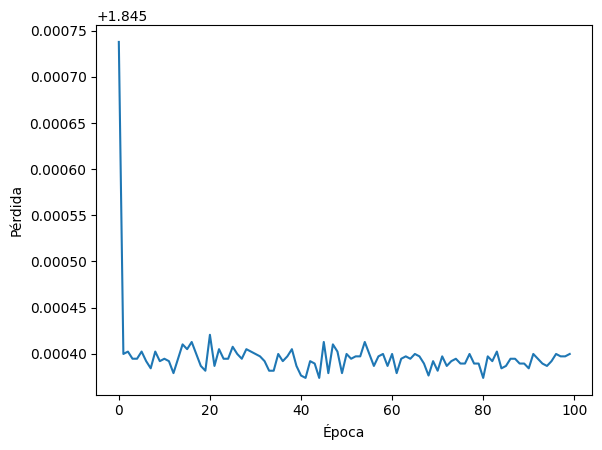

In [27]:
plt.plot(error)
plt.xlabel("Época")
plt.ylabel("Pérdida")
plt.show()

In [28]:
def confusion(y_true, y_pred):
  ''' Calcula la matriz de confución dado un MODEL y un DATA_LOADER '''
  n = len(classes)
  matrix = torch.zeros(n,n)
  for true, pred in zip(y_true, y_pred):
    matrix[true][pred] += 1

  plt.imshow(matrix, cmap="Blues")
  plt.title("Matriz de confusión")
  plt.ylabel("Valores correctos")
  plt.xlabel("Predicciones")
  new_classes = classes.copy()
  new_classes[0] = " Curious"
  plt.xticks(torch.arange(n), new_classes, rotation=45)
  plt.yticks(torch.arange(n), new_classes)
  plt.show()

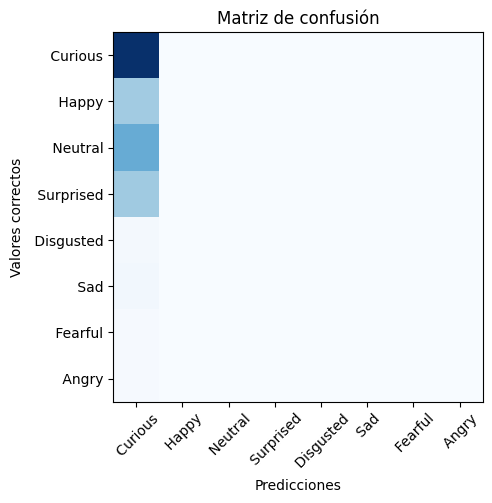

In [29]:
confusion(y_true, y_pred)

In [52]:
def predict(model, text, device):
  d = test_dataloader.dataset.X.shape[1]
  pad = torch.zeros(1, d, dtype=torch.long)
  tk = vocab(tokenizer(text))
  pad[0,:len(tk)] = torch.tensor(tk, dtype=torch.long)
  model.eval()
  with torch.no_grad():
    r = torch.softmax(model(pad.to(device), None), dim=1).argmax()
  return classes[r]

In [63]:
predict(model, "I'm sad", device)

' Curious to dive deeper'

### Resultados

Los resultaados no fueron muy satisfactorios pero eran un poco esperados por, al menos, dos razones que pudimos notar: Nos hubiera gusta usar más cabezas para el módulo de atención pero 100 ya alentaba bastante el proceso, y hubiera sido ideal encontrar un mejor modelo o tratar de normalizar las distribución de las clases porque la red de decanta por *curious to dive deeper* por lo predominante que es. También tuvimos problemas al tratar de aplicar las máscaras para el padding y la función de pérdida se volvia nan al usarlas.